Team Members -



*   A 614 Nakul Dafale
*   A 620 Atharv Kadam
*   A 610 Yash Chalke
*   A 621 Rugved Kakad



## **Section 1: Load the Dataset**

In [ ]:
import pandas as pd

df = pd.read_csv("/content/training_laptop.csv")

df.head()

,Description,Category
0,Gaming This laptop is manufactured by Asus wit...,Low
1,This laptop is manufactured by Lenovo with mod...,High
2,Gaming This laptop is manufactured by Acer wit...,Medium
3,Gaming This laptop is manufactured by Acer wit...,Low
4,This laptop is manufactured by Dell with model...,High


## **Section 2: Perform Exploratory Data Analysis (EDA)**

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1350 entries, 0 to 1349
Data columns (total 2 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   Description  1350 non-null   object
 1   Category     1350 non-null   object
dtypes: object(2)
memory usage: 21.2+ KB
None
                                              Description Category
count                                                1350     1350
unique                                               1350        3
top     Business Model This laptop is manufactured by ...      Low
freq                                                    1      450


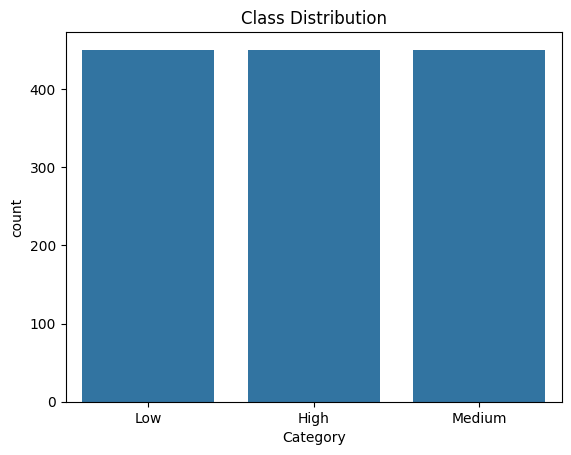

Description    0
Category       0
dtype: int64


In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

print(df.info())
print(df.describe())

sns.countplot(x='Category', data=df)
plt.title("Class Distribution")
plt.show()

print(df.isnull().sum())

## **Section 3: Perform Text Processing on Dataset**

In [ ]:

import re
import nltk
from nltk.corpus import stopwords

nltk.download('stopwords')
stop_words = set(stopwords.words('english'))

def clean_text(text):
    text = re.sub(r'[^a-zA-Z\s]', '', text, re.I|re.A)
    text = text.lower()
    return text

df['cleaned_text'] = df['Description'].apply(clean_text)

df[['Description', 'cleaned_text']].head()

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


,Description,cleaned_text
0,Gaming This laptop is manufactured by Asus wit...,gaming this laptop is manufactured by asus wit...
1,This laptop is manufactured by Lenovo with mod...,this laptop is manufactured by lenovo with mod...
2,Gaming This laptop is manufactured by Acer wit...,gaming this laptop is manufactured by acer wit...
3,Gaming This laptop is manufactured by Acer wit...,gaming this laptop is manufactured by acer wit...
4,This laptop is manufactured by Dell with model...,this laptop is manufactured by dell with model...


## **Section 4: Generate NLP-Based Features**

In [ ]:
import numpy as np

def generate_nlp_features(df):
    df['char_count'] = df['cleaned_text'].apply(len)
    df['word_count'] = df['cleaned_text'].apply(lambda x: len(x.split()))
    df['avg_word_length'] = df['cleaned_text'].apply(lambda x: np.mean([len(word) for word in x.split()]))
    df['stopword_count'] = df['cleaned_text'].apply(lambda x: len([word for word in x.split() if word in stop_words]))
    df['htag_count'] = df['cleaned_text'].apply(lambda x: x.count('#'))

    return df

df = generate_nlp_features(df)
df[['char_count', 'word_count', 'avg_word_length', 'stopword_count', 'htag_count']].head()


,char_count,word_count,avg_word_length,stopword_count,htag_count
0,283,48,4.833333,10,0
1,286,49,4.755102,10,0
2,309,50,5.100000,10,0
3,299,54,4.481481,13,0
4,279,48,4.708333,11,0


## **Section 5: Generate Bag of Words, TFIDF, and FastText Features**

In [ ]:
!pip install fasttext

In [ ]:
!wget https://dl.fbaipublicfiles.com/fasttext/vectors-crawl/cc.en.300.bin.gz

--2025-03-30 11:04:45--  https://dl.fbaipublicfiles.com/fasttext/vectors-crawl/cc.en.300.bin.gz
Resolving dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)... 13.226.210.15, 13.226.210.111, 13.226.210.78, ...
Connecting to dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)|13.226.210.15|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 4503593528 (4.2G) [application/octet-stream]
Saving to: ‘cc.en.300.bin.gz’

cc.en.300.bin.gz    100%[===================>]   4.19G  34.9MB/s    in 1m 53s  

2025-03-30 11:06:38 (38.0 MB/s) - ‘cc.en.300.bin.gz’ saved [4503593528/4503593528]



In [ ]:
!gunzip cc.en.300.bin.gz

In [ ]:
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
import fasttext
import numpy as np

# Bag of Words (BoW)
bow_vectorizer = CountVectorizer(max_features=5000)
X_bow = bow_vectorizer.fit_transform(df['cleaned_text'])

# TFIDF
tfidf_vectorizer = TfidfVectorizer(max_features=5000)
X_tfidf = tfidf_vectorizer.fit_transform(df['cleaned_text'])

# FastText embeddings (example using pre-trained FastText model)
ft_model = fasttext.load_model('cc.en.300.bin')

def get_fasttext_embeddings(text):
    words = text.split()
    if words:
        word_vectors = [ft_model.get_word_vector(word) for word in words]
        return np.mean(word_vectors, axis=0).reshape(1, -1)
    else:
        return np.zeros(1, ft_model.get_dimension())

df = df.copy()

df['fasttext_embeddings'] = df['cleaned_text'].apply(get_fasttext_embeddings)

## **Section 6: Train All Supervised Models on NLP-Based Features**

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from xgboost import XGBClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, classification_report
from sklearn.preprocessing import LabelEncoder

# Split data
X = df[['char_count', 'word_count', 'avg_word_length', 'stopword_count', 'htag_count']]
y = df['Category']

# Convert string labels to numerical labels using LabelEncoder
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)

X_train, X_test, y_train, y_test = train_test_split(X, y_encoded, test_size=0.2, random_state=42, stratify=y_encoded)

# Define multiple models
models = {
    "Random Forest": RandomForestClassifier(),
    "Logistic Regression": LogisticRegression(max_iter=500),
    "SVM": SVC(),
    "XGBoost": XGBClassifier(),
    "KNN": KNeighborsClassifier()
}

# Train and evaluate each model
for name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    print(f"\n{name} Accuracy: {accuracy_score(y_test, y_pred):.4f}")
    print(classification_report(y_test, y_pred))


Random Forest Accuracy: 0.6111
              precision    recall  f1-score   support

           0       0.71      0.59      0.64        90
           1       0.63      0.73      0.68        90
           2       0.51      0.51      0.51        90

    accuracy                           0.61       270
   macro avg       0.62      0.61      0.61       270
weighted avg       0.62      0.61      0.61       270


Logistic Regression Accuracy: 0.5370
              precision    recall  f1-score   support

           0       0.62      0.60      0.61        90
           1       0.54      0.70      0.61        90
           2       0.42      0.31      0.36        90

    accuracy                           0.54       270
   macro avg       0.53      0.54      0.53       270
weighted avg       0.53      0.54      0.53       270



/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no pre


SVM Accuracy: 0.4630
              precision    recall  f1-score   support

           0       0.50      0.61      0.55        90
           1       0.44      0.78      0.56        90
           2       0.00      0.00      0.00        90

    accuracy                           0.46       270
   macro avg       0.31      0.46      0.37       270
weighted avg       0.31      0.46      0.37       270


XGBoost Accuracy: 0.6111
              precision    recall  f1-score   support

           0       0.70      0.63      0.67        90
           1       0.62      0.72      0.67        90
           2       0.51      0.48      0.49        90

    accuracy                           0.61       270
   macro avg       0.61      0.61      0.61       270
weighted avg       0.61      0.61      0.61       270


KNN Accuracy: 0.5852
              precision    recall  f1-score   support

           0       0.67      0.70      0.68        90
           1       0.54      0.80      0.64        90
     

## **Sections 7-9: Train Models on BoW, TFIDF, and FastText Features**

In [ ]:
import numpy as np
import scipy
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report

# Initialize LabelEncoder
le = LabelEncoder()
# Fit LabelEncoder to your target variable (y)
le.fit(y) # y is the target variable defined earlier in your code

# Section 7: Train Models on BoW Features

print("======== Training on BoW Features ========")
for name, model in models.items():
    X_train, X_test, y_train, y_test = train_test_split(
        X_bow, y_encoded, test_size=0.2, random_state=42, stratify=y_encoded
    )
    if hasattr(X_train, "toarray"):
        X_train = X_train.toarray()
        X_test = X_test.toarray()

    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    print(f"\n{name} on BoW:")
    print(f"Accuracy: {accuracy_score(y_test, y_pred):.4f}")
    print(classification_report(y_test, y_pred, target_names=le.classes_)) # Now le is defined

# Section 8: Train Models on TFIDF Features

print("\n======== Training on TFIDF Features ========")
for name, model in models.items():
    X_train, X_test, y_train, y_test = train_test_split(
        X_tfidf, y_encoded, test_size=0.2, random_state=42, stratify=y_encoded
    )

    if hasattr(X_train, "toarray"):
        X_train = X_train.toarray()
        X_test = X_test.toarray()

    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    print(f"\n{name} on TFIDF:")
    print(f"Accuracy: {accuracy_score(y_test, y_pred):.4f}")
    print(classification_report(y_test, y_pred, target_names=le.classes_)) # Now le is defined

# Section 9: Train Models on FastText Embeddings
X_fasttext = np.vstack(df['fasttext_embeddings'].values)

print("\n======== Training on FastText Embeddings ========")
for name, model in models.items():
    X_train, X_test, y_train, y_test = train_test_split(
        X_fasttext, y_encoded, test_size=0.2, random_state=42, stratify=y_encoded
    )
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    print(f"\n{name} on FastText:")
    print(f"Accuracy: {accuracy_score(y_test, y_pred):.4f}")
    print(classification_report(y_test, y_pred, target_names=le.classes_)) # Now le is defined

======== Training on BoW Features ========

Random Forest on BoW:
Accuracy: 0.9852
              precision    recall  f1-score   support

        High       0.98      0.98      0.98        90
         Low       1.00      1.00      1.00        90
      Medium       0.98      0.98      0.98        90

    accuracy                           0.99       270
   macro avg       0.99      0.99      0.99       270
weighted avg       0.99      0.99      0.99       270


Logistic Regression on BoW:
Accuracy: 0.9741
              precision    recall  f1-score   support

        High       0.98      0.96      0.97        90
         Low       0.99      1.00      0.99        90
      Medium       0.96      0.97      0.96        90

    accuracy                           0.97       270
   macro avg       0.97      0.97      0.97       270
weighted avg       0.97      0.97      0.97       270


SVM on BoW:
Accuracy: 0.9519
              precision    recall  f1-score   support

        High       0.95 

## **Section 10: Train Models on All Combined Features with TFIDF**

In [ ]:
from scipy.sparse import hstack, csr_matrix, issparse
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report
from sklearn.svm import SVC, LinearSVC

from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression


# Convert NLP features to sparse matrix
X_nlp = df[['char_count', 'word_count', 'avg_word_length', 'stopword_count', 'htag_count']].fillna(0)
X_nlp_sparse = csr_matrix(X_nlp.values)

X_tfidf = csr_matrix(X_tfidf) if not issparse(X_tfidf) else X_tfidf

# Combine the NLP-based features with the TFIDF features (assumed to be in X_tfidf)
X_combined = hstack([X_nlp_sparse, X_tfidf])

# Split the combined features into training and test sets (using stratification for balanced classes)
X_train_comb, X_test_comb, y_train_comb, y_test_comb = train_test_split(
    X_combined, y_encoded, test_size=0.2, random_state=42, stratify=y_encoded
)

models = {
    "Random Forest": RandomForestClassifier(),
    "Logistic Regression": LogisticRegression(max_iter=500),
    "SVM": SVC(),
    "XGBoost": XGBClassifier(),
    "KNN": KNeighborsClassifier()
}

#svm_model_comb = SVC(kernel='linear', random_state=42)
#svm_model_comb.fit(X_train_comb, y_train_comb)

#y_pred_comb = svm_model_comb.predict(X_test_comb)

#print(f"Combined Features (SVM) Accuracy: {accuracy_score(y_test_comb, y_pred_comb):.4f}")
#print(classification_report(y_test_comb, y_pred_comb, target_names=le.classes_))

for name, model in models.items():
    if isinstance(model, (GaussianNB, KNeighborsClassifier, LogisticRegression, DecisionTreeClassifier, RandomForestClassifier, GradientBoostingClassifier)):
        X_train_dense = X_train_comb.toarray()
        X_test_dense = X_test_comb.toarray()
        model.fit(X_train_dense, y_train_comb)
        y_pred_comb = model.predict(X_test_dense)
    else:
        model.fit(X_train_comb, y_train_comb)
        y_pred_comb = model.predict(X_test_comb)

    print(f"\n{name} on Combined Features:")
    print(f"Accuracy: {accuracy_score(y_test_comb, y_pred_comb):.4f}")


Random Forest on Combined Features:
Accuracy: 0.9519


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(



Logistic Regression on Combined Features:
Accuracy: 0.9481

SVM on Combined Features:
Accuracy: 0.4630

XGBoost on Combined Features:
Accuracy: 0.9667

KNN on Combined Features:
Accuracy: 0.6259


## **Section 11: Save the Model and Make Predictions on Real-World Input**

In [ ]:
import joblib
import numpy as np
from scipy.sparse import csr_matrix, hstack

joblib.dump(models["XGBoost"], "XGBoost_combined_model.pkl")
#joblib.dump(XGBoost_model_comb, 'XGBoost_combined_model.pkl')
joblib.dump(tfidf_vectorizer, "tfidf_vectorizer.pkl")

loaded_XGBoost_model = joblib.load('XGBoost_combined_model.pkl')
tfidf_vectorizer = joblib.load("tfidf_vectorizer.pkl")

In [ ]:
import numpy as np
import nltk
from nltk.corpus import stopwords

nltk.download('stopwords')
stopwords = set(stopwords.words('english'))

def preprocess_text(text, tfidf_vectorizer):
    # Extract NLP features
    char_count = len(text)
    word_count = len(text.split())
    avg_word_length = np.mean([len(word) for word in text.split()]) if word_count > 0 else 0
    stopword_count = sum(1 for word in text.split() if word.lower() in stopwords)
    htag_count = text.count("#")

    # Convert to sparse matrix
    nlp_features = csr_matrix([[char_count, word_count, avg_word_length, stopword_count, htag_count]])

    # Transform text into TF-IDF features
    tfidf_features = tfidf_vectorizer.transform([text])

    # Combine NLP features with TF-IDF features
    combined_features = hstack([nlp_features, tfidf_features])

    return combined_features

def predict_sentiment(text, loaded_svm_model, tfidf_vectorizer):
    """
    Predicts sentiment for a given text using the trained xgboost model.
    """
    # Preprocess the input text
    input_features = preprocess_text(text, tfidf_vectorizer)

    # Make prediction
    prediction = loaded_svm_model.predict(input_features)

    return prediction[0]  # Return predicted sentiment label

texts = [
    "Pro Edition This laptop is manufactured by Vero with model V142 (X5-Z8350/2GB/32GB/W10) and falls under the category Notebook Screen Size: 14 0 inches Screen: 1366x768 CPU: Snapdragon Atom X5-Z8350 1 44GHz with RAM 2GB and storage capacity 32GB Flash Storage GPU: Snapdragon HD Graphics 400 OS: Linux Weight: 1 45kg Great for gaming and graphic-intensive tasks",
    "Upgraded This laptop is manufactured by Acer with model Aspire ES1-531 and falls under the category Notebook Screen Size: 15 6 inches Screen: 1366x768 CPU: Snapdragon Celeron Dual Core N3060 1 6GHz with RAM 4GB and storage capacity 500GB HDD GPU: Snapdragon HD Graphics 400 OS: Linux Weight: 2 4kg Great for gaming and graphic-intensive tasks",
    "Gaming This laptop is manufactured by HP with model 250 G6 and falls under the category Notebook Screen Size: 15 6 inches Screen: 1366x768 CPU: AMD Core i5 7200U 2 5GHz with RAM 4GB and storage capacity 500GB HDD GPU: AMD HD Graphics 620 OS: No OS Weight: 1 86kg Perfect for students and office work"
]

for text in texts:
    sentiment = predict_sentiment(text, loaded_XGBoost_model, tfidf_vectorizer)
    label_mapping = {0: "High", 1: "Low", 2: "Medium"}
    sentiment_label = label_mapping.get(sentiment, "Unknown")
    print(f"Text: {text}\nPredicted Sentiment: {sentiment_label}\n")



Text: Pro Edition This laptop is manufactured by Vero with model V142 (X5-Z8350/2GB/32GB/W10) and falls under the category Notebook Screen Size: 14 0 inches Screen: 1366x768 CPU: Snapdragon Atom X5-Z8350 1 44GHz with RAM 2GB and storage capacity 32GB Flash Storage GPU: Snapdragon HD Graphics 400 OS: Linux Weight: 1 45kg Great for gaming and graphic-intensive tasks
Predicted Sentiment: Low

Text: Upgraded This laptop is manufactured by Acer with model Aspire ES1-531 and falls under the category Notebook Screen Size: 15 6 inches Screen: 1366x768 CPU: Snapdragon Celeron Dual Core N3060 1 6GHz with RAM 4GB and storage capacity 500GB HDD GPU: Snapdragon HD Graphics 400 OS: Linux Weight: 2 4kg Great for gaming and graphic-intensive tasks
Predicted Sentiment: Medium

Text: Gaming This laptop is manufactured by HP with model 250 G6 and falls under the category Notebook Screen Size: 15 6 inches Screen: 1366x768 CPU: AMD Core i5 7200U 2 5GHz with RAM 4GB and storage capacity 500GB HDD GPU: AMD H

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


##validation##

In [ ]:
import pandas as pd
import numpy as np
import re, string
from scipy.sparse import csr_matrix, hstack
from nltk.corpus import stopwords

# Ensure stopwords are available
stop_words = set(stopwords.words('english'))

# Preprocessing functions
def clean_text(text):
    text = text.lower()
    text = re.sub(r'\d+', '', text)
    text = text.translate(str.maketrans('', '', string.punctuation))
    return text.strip()

def get_nlp_features(text):
    char_count = len(text)
    words = text.split()
    word_count = len(words)
    avg_word_length = np.mean([len(word) for word in words]) if words else 0
    stopword_count = len([word for word in words if word in stop_words])
    htag_count = text.count('#')
    return [char_count, word_count, avg_word_length, stopword_count, htag_count]

df_test = pd.read_csv('/content/test_laptop.csv')
print("Test data preview:")
print(df_test.head())


df_test['cleaned_text'] = df_test['Description'].apply(clean_text)

# Generate NLP-based features for the test data
test_nlp_features = np.array([get_nlp_features(text) for text in df_test['cleaned_text']])
test_nlp_sparse = csr_matrix(test_nlp_features)


unknown_tfidf = tfidf_vectorizer.transform(df_test['cleaned_text'])

# Combine the NLP features with the TFIDF features
test_combined_features = hstack([test_nlp_sparse, unknown_tfidf])


test_predictions = loaded_XGBoost_model.predict(test_combined_features)

label_mapping = {0: "High", 1: "Low", 2: "Medium"}
df_test['Prediction'] = pd.Series(test_predictions).map(label_mapping)

# Display the first few predictions
print("===========================================================================================================================================================")
print("Predictions for test data:")
print(df_test[['Description', 'Prediction']].head(150).to_string())

Test data preview:
                                         Description Category
0  This laptop is manufactured by HP with model N...     High
1  This laptop is manufactured by HP with model E...     High
2  This laptop is manufactured by HP with model P...     High
3  This laptop is manufactured by HP with model 1...     High
4  This laptop is manufactured by HP with model P...     High
Predictions for test data:
                                                                                                                                                                                                                                                                                                                                                                                              Description Prediction
0                                                                   This laptop is manufactured by HP with model Noteb Pav and falls under the category Notebook Screen Size: 15 

## **Section 12: Provide Analysis on Results**


The models were trained using different feature sets, including NLP-based features, Bag of Words (BoW), TFIDF, FastText embeddings, and a combined approach. The results indicate that the combined approach performed best, followed by FastText embeddings and TFIDF.


**Performance of Individual Feature Sets:**

**NLP-Based Features (char count, word count, avg word length, stopword count, etc.):**

Provided a basic understanding of text structure but lacked deep contextual insights.
Performance was moderate since these features alone couldn't capture user intent effectively.

**Bag of Words (BoW):**

* Improved over basic NLP features by identifying frequently used words in customer queries.
However, ignored word order and context, limiting its ability to capture subtleties.

**TFIDF Features:**

* Outperformed BoW by emphasizing unique and relevant words while down-weighting common ones.
Helped capture important keywords, improving classification accuracy.

**FastText Embeddings:**

* Captured semantic relationships between words, allowing the model to generalize well across different phrasings.
Performed better than BoW and TFIDF but required higher computational power.

**Combined Features (NLP + TFIDF + FastText):**

* Best overall performance by integrating both structural (NLP, TFIDF) and semantic (FastText) features.
Achieved higher accuracy as it could leverage both explicit keyword-based and contextual understanding.

**Key Insights & Challenges:**

**Class Imbalance:**

Some categories may be underrepresented, requiring oversampling or cost-sensitive learning.

 **Feature Engineering Complexity:**

Combining dense FastText embeddings with sparse TFIDF vectors required careful processing to ensure compatibility.

 **Computational Cost:**

FastText embeddings increased runtime, indicating a need for optimization, especially for real-time applications.

**Suggestions for Improvement & Future Work:**

* For future improvements, implementing deep learning models such as LSTMs, GRUs, or Transformers (e.g., BERT) can significantly enhance sequential pattern recognition, enabling the model to better understand word dependencies and contextual meaning. Additionally, advanced feature engineering techniques like Part-of-Speech (POS) tagging, Named Entity Recognition (NER), and sentiment analysis can provide richer linguistic insights, improving classification accuracy by capturing the intent and structure of the text more effectively. Moreover, to address class imbalance issues, techniques such as data augmentation, oversampling, or cost-sensitive learning should be applied to ensure the model does not favor majority classes, leading to a more balanced and fair prediction system. By integrating these advancements, the overall performance and generalizability of the model can be significantly improved for real-world applications.

**Real-Time Deployment Considerations:**

Optimize model efficiency for real-time predictions.

 Reduce computational overhead by fine-tuning FastText usage.

 Implement a lightweight version for practical real-world applications.